### Statistical Data Analysis
In the data story section of this project, I investigated correlations between variables and found many. In this section I will look for differences betweeen subgroups.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

In [2]:
# In the first part of this project, I merged and cleaned the data I found and saved it as 'capstone1_data.pkl'
df = pd.read_pickle('Data/capstone1_data.pkl')

In [3]:
df.loc[:, df.dtypes == 'category'].head()

perpov10 perchldpov10 metro13 poploss10
State   County  FIPS                                        
Alabama Autauga 1001      0.0          0.0     1.0       0.0
        Baldwin 1003      0.0          0.0     1.0       0.0
        Barbour 1005      1.0          1.0     0.0       0.0
        Bibb    1007      0.0          1.0     1.0       0.0
        Blount  1009      0.0          0.0     1.0       0.0

In [4]:
# DataCamp bootstrap functions
def bootstrap_replicate_1d(data, func):
    return func(np.random.choice(data, size=len(data)))

def draw_bs_reps(data, func, size=1):
    """Draw bootstrap replicates."""

    # Initialize array of replicates: bs_replicates
    bs_replicates = np.empty(size)

    # Generate replicates
    for i in range(size):
        bs_replicates[i] = bootstrap_replicate_1d(data, func)

    return bs_replicates

In [5]:
# My bootstrap function
def compare(data1, data2, func, confidence=95, size=1):
    bs1 = draw_bs_reps(data1, func, size)
    bs2 = draw_bs_reps(data2, func, size)
    bs_diff = bs2 - bs1
    bs_confidence = np.percentile(bs_diff, [(100-confidence)/2, 95 + (100-confidence)/2])
    measured_diff = func(bs2) - func(bs1)
    
    return {'measured': measured_diff, 'bs_low': bs_confidence[0], 'bs_high': bs_confidence[1], 'bootstrap': bs_diff}

In [6]:
categorical_columns = df.loc[:, df.dtypes == 'category'].columns
bootstrap_categorical = {}
for col in categorical_columns:
    bootstrap_categorical[col] = compare(df.loc[df[col] == 0, 'conv_to_groc'].dropna(),
                                         df.loc[df[col] == 1, 'conv_to_groc'].dropna(),
                                         np.mean,
                                         95,
                                         10000)
    print(col, list(bootstrap_categorical[col][x] for x in ['measured', 'bs_low', 'bs_high']))

perpov10 [0.7364654949125558, 0.5260029876400372, 0.9534180821563606]
perchldpov10 [0.6956040158930263, 0.5428248648358392, 0.8472813437591638]
metro13 [0.024617031533499478, -0.0956860583393435, 0.14124155333963917]
poploss10 [-0.6199780781430371, -0.7654485843663876, -0.4715944326054011]


If the confidence interval overlaps 0 like for metro13, there is no significant difference. The subgroups of the other three variables, however, do have a significant difference in the mean ratio of convenience to grocery stores.

In [7]:
for col in categorical_columns:
    print(col, ttest_ind(df.loc[df[col] == 0, 'conv_to_groc'].dropna(),
                    df.loc[df[col] == 1, 'conv_to_groc'].dropna())[1])

perpov10 6.6957610254369275e-15
perchldpov10 7.103099669424847e-23
metro13 0.6830454548523173
poploss10 8.291778807438015e-15


The t-test gives the same result as bootstrapping a 95% confidence interval.

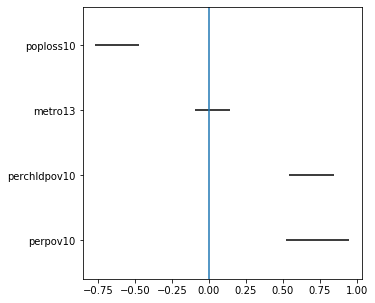

In [8]:
bs_cat = pd.DataFrame(bootstrap_categorical).transpose()
errors = np.array(list(zip(abs(bs_cat['bs_high']-bs_cat['measured']), abs(bs_cat['bs_low']-bs_cat['measured'])))).transpose()
plt.figure(figsize=(5,5))
plt.barh(bs_cat.index, bs_cat['measured'], xerr=errors, color='white')
plt.axvline(0)

In [9]:
categorical_columns = ['perpov10', 'perchldpov10']
bootstrap_categorical = {}
for col in categorical_columns:
    bootstrap_categorical[col] = compare(df.loc[df[col] == 0, 'povrate15'].dropna(),
                                         df.loc[df[col] == 1, 'povrate15'].dropna(),
                                         np.mean,
                                         95,
                                         10000)
    print(col, list(bootstrap_categorical[col][x] for x in ['measured', 'bs_low', 'bs_high']))

perpov10 [13.221165912702796, 12.584948497222527, 13.876804962864862]
perchldpov10 [10.408728444080392, 9.927212606639813, 10.883217927423795]


In [10]:
categorical_columns = ['perpov10', 'perchldpov10']
bootstrap_categorical = {}
for col in categorical_columns:
    bootstrap_categorical[col] = compare(df.loc[df[col] == 0, 'povrate15'].dropna(),
                                         df.loc[df[col] == 1, 'povrate15'].dropna(),
                                         np.median,
                                         95,
                                         10000)
    print(col, list(bootstrap_categorical[col][x] for x in ['measured', 'bs_low', 'bs_high']))

perpov10 [12.200000000000001, 11.399999999999999, 13.099999999999998]
perchldpov10 [9.799999999999999, 9.2, 10.399999999999999]


In [11]:
from sklearn.metrics import confusion_matrix
confusion_matrix(df['perpov10'], df['perchldpov10'])

array([[2426,  362],
       [   7,  344]], dtype=int64)

Very often both 'perpov10' and 'perchldpov10' are both 0.  
If 'perchldpov10' is 1, there is ~50% chance that 'perpov10' is 1 as well.  
If 'perpov10' is 1, there is ~98% chance that 'perchldpov10' is 1 as well.